# Bank Marketing — Random Forest 
**Goal:** Predict if a client will subscribe to a term deposit (target `y`).  
**Dataset:** UCI Bank Marketing (`bank-additional-full.csv`).  
**Author:** Steffin Thomas — polished end-to-end ML workflow with explainability and business framing.

TL;DR: pipeline → RandomForest (calibrated) → tuned with stratified CV → explainable via SHAP + permutation importance → saved as `models/rf_bank_marketing_calibrated.joblib`.


In [1]:
# Environment & reproducibility
import sys, os, json, datetime
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

import sklearn, joblib
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

print("Python:", sys.version.split()[0])
print("sklearn:", sklearn.__version__)
print("Run at:",  datetime.datetime.now(datetime.timezone.utc), "UTC")

Python: 3.12.7
sklearn: 1.5.1
Run at: 2025-08-13 10:21:45.367961+00:00 UTC


In [2]:
DATA_PATH = "bank-additional-full.csv"
df = pd.read_csv(DATA_PATH)
print("shape:", df.shape)
display(df.head())

shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [7]:
# Quick metadata & target balance
df.info()
print("Target proportion (y): ")
display(df['y'].value_counts(normalize=True).rename('proportion').round(3))
print("\n'unknown' counts (categorical fields):")
display((df == 'unknown').sum().sort_values(ascending=False).loc[lambda x: x>0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

y
no     0.887
yes    0.113
Name: proportion, dtype: float64


'unknown' counts (categorical fields):


default      8597
education    1731
housing       990
loan          990
job           330
marital        80
dtype: int64

# Initial EDA (visual)
- Target balance, some key categorical & numerical visuals.

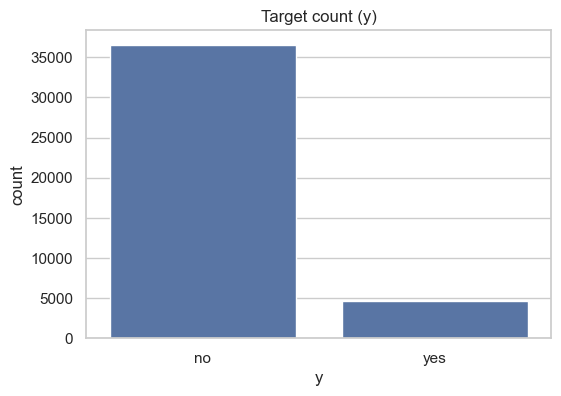

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(x='y', data=df)
plt.title("Target count (y)")
plt.show()

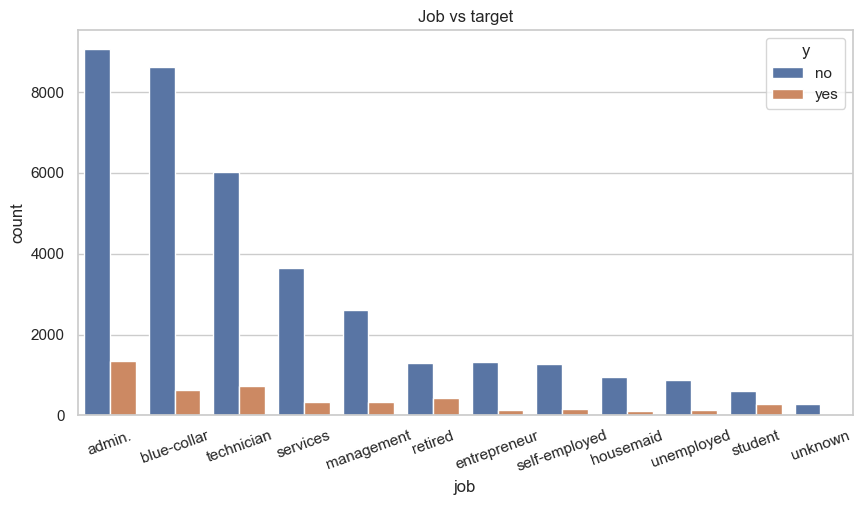

In [24]:
plt.figure(figsize=(10,5))
sns.countplot(x='job', hue='y', data=df, order=df['job'].value_counts().index)
plt.xticks(rotation =20)
plt.title("Job vs target")
plt.show()

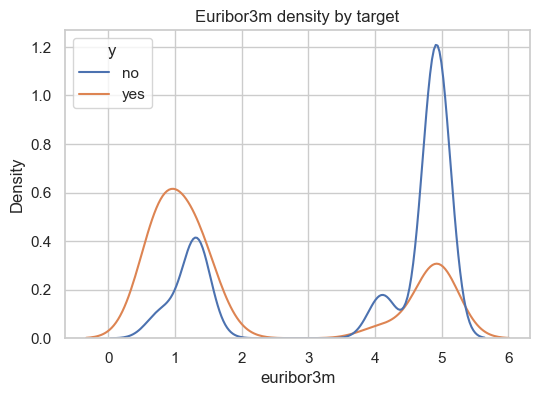

In [31]:
plt.figure(figsize=(6,4))
sns.kdeplot(x='euribor3m', hue='y', data=df, common_norm=False)
plt.title("Euribor3m density by target")
plt.show()

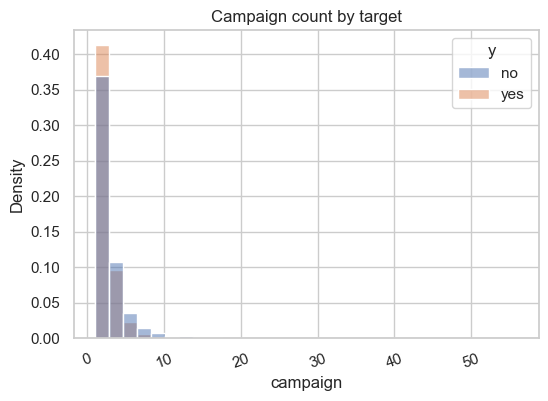

In [37]:
plt.figure(figsize=(6,4))
sns.histplot(x='campaign', hue='y', data=df, stat='density',bins=30, common_norm = False)
plt.xticks(rotation =20)
plt.title("Campaign count by target")
plt.show()

# Leakage check & feature engineering
- Drop `duration` (leakage).  
- Create interpretable pdays features.

In [55]:
df2 = df.copy()

if 'duration' in df2.columns:
    df2.drop(columns=['duration'], axis=1, inplace=True)

df2['was_prev_contacted'] = (df2['pdays'] != 999).astype(int)
df2['pdays_when_contacted'] = df2['pdays'].replace({999:np.nan})

df2['target'] = (df2['y'] == 'yes').astype(int)
df2.drop(columns=['y','pdays'], axis=1, inplace=True)

display(df2.head())
print("Shape after transformation: ", df2.shape)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,was_prev_contacted,pdays_when_contacted,target
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,NaN,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,NaN,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,NaN,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,NaN,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,NaN,0


Shape after transformation:  (41188, 21)


# Column typing: categorical vs numeric

In [80]:
cat_cols = df2.select_dtypes(include='object').columns.tolist()
num_cols = df2.select_dtypes(exclude='object').columns.tolist()

if 'target' in num_cols:
    num_cols.remove('target')
if 'target' in cat_cols:
    cat_cols.remove('target')

print("categorical columns:", cat_cols)
print("numeric columns:", num_cols)

categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numeric columns: ['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'was_prev_contacted', 'pdays_when_contacted']


# Handle 'unknown'
- Decision: keep `'unknown'` as a category (it can be informative). We'll encode it with OneHotEncoder.
If you prefer imputing, you can replace 'unknown' with mode per column instead.

In [81]:
unknown_counts = {c: (df2[c]=='unknown').sum() for c in cat_cols}
unknown_counts

{'job': 330,
 'marital': 80,
 'education': 1731,
 'default': 8597,
 'housing': 990,
 'loan': 990,
 'contact': 0,
 'month': 0,
 'day_of_week': 0,
 'poutcome': 0}

# Train/test split (stratified)

In [82]:
from sklearn.model_selection import train_test_split

X = df2.drop(columns='target')
y= df2['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE)

print("Train: ",X_train.shape, " Test: ", X_test.shape)

Train:  (30891, 20)  Test:  (10297, 20)


# Preprocessor & baseline pipeline
- OneHotEncoder for categorical (handle_unknown='ignore'), passthrough numeric.
- RandomForest with balanced class weight to help with target imbalance.

In [83]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

preprocessor = ColumnTransformer(
    transformers=[
    ('cat',OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    ('num', 'passthrough', num_cols)
], remainder='drop')

rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1, oob_score=True)
pipeline = Pipeline([('pre', preprocessor), ('clf', rf)])

# Baseline fit & quick metrics

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      9137
           1       0.55      0.26      0.36      1160

    accuracy                           0.89     10297
   macro avg       0.73      0.62      0.65     10297
weighted avg       0.87      0.89      0.88     10297

Accuracy score:  0.8930756531028455
ROC-AUC: 0.779722132066286
PR-AUC (avg precision): 0.4273121786397053


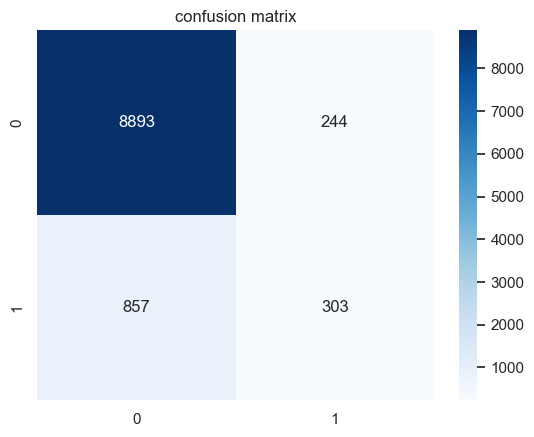

In [88]:
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, accuracy_score, confusion_matrix

pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print('Accuracy score: ', accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))
print("PR-AUC (avg precision):", average_precision_score(y_test, y_proba))
      
sns.heatmap(confusion_matrix(y_test, y_pred), fmt='d', annot=True, cmap='Blues')
plt.title("confusion matrix")
plt.show()

# Quick hyperparameter tuning (fast mode)
- Option A: Quick RandomizedSearch on a **subset** (recommended when developing).
- Option B: Full RandomizedSearch using whole training data (takes longer).

In [90]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint

max_samples_search = min(12000, len(X_train))
subset_idx = np.random.RandomState(RANDOM_STATE).choice(len(X_train), size=max_samples_search, replace=False)
X_s = X_train.iloc[subset_idx]; y_s = y_train.iloc[subset_idx]

param_dist = {
    'clf__n_estimators': randint(200, 600),
    'clf__max_depth': randint(6, 25),
    'clf__min_samples_split': randint(2, 20),
    'clf__min_samples_leaf': randint(1, 10),
    'clf__max_features': ['sqrt','log2', 0.3, 0.5, None]
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)
rs = RandomizedSearchCV(pipeline, param_dist, n_iter=24, scoring='roc_auc', cv=cv, n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
rs.fit(X_s, y_s)

print("Best params (quick):", rs.best_params_)
print("Best cv score (quick):", rs.best_score_)
best_pipeline_quick = rs.best_estimator_

Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best params (quick): {'clf__max_depth': 6, 'clf__max_features': 0.5, 'clf__min_samples_leaf': 8, 'clf__min_samples_split': 12, 'clf__n_estimators': 280}
Best cv score (quick): 0.8021771415806244


#  Full search refinement
- Use the `rs.best_params_` to build a small grid around the best region and run GridSearchCV on full training set.

In [92]:
from sklearn.model_selection import GridSearchCV

best = rs.best_params_
grid_params = {
    'clf__n_estimators': [best['clf__n_estimators'], best['clf__n_estimators']+200],
    'clf__max_depth': [max(3, best['clf__max_depth']-2), best['clf__max_depth'], best['clf__max_depth']+2],
    'clf__min_samples_split': [max(2, best['clf__min_samples_split']-2), best['clf__min_samples_split'], best['clf__min_samples_split']+2],
    'clf__min_samples_leaf': [max(1, best['clf__min_samples_leaf']-1), best['clf__min_samples_leaf'], best['clf__min_samples_leaf']+1],
    'clf__max_features': [best['clf__max_features']],
}

grid = GridSearchCV(rs.best_estimator_, grid_params, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print("Best params (grid):", grid.best_params_)
print("Best cv score (grid):", grid.best_score_)
best_pipeline = grid.best_estimator_

Fitting 4 folds for each of 54 candidates, totalling 216 fits
Best params (grid): {'clf__max_depth': 8, 'clf__max_features': 0.5, 'clf__min_samples_leaf': 9, 'clf__min_samples_split': 10, 'clf__n_estimators': 480}
Best cv score (grid): 0.79883508522255


#  Final fit on full training set

              precision    recall  f1-score   support

           0       0.95      0.88      0.91      9137
           1       0.40      0.64      0.49      1160

    accuracy                           0.85     10297
   macro avg       0.68      0.76      0.70     10297
weighted avg       0.89      0.85      0.87     10297

Accuracy score:  0.85083033893367
ROC-AUC: 0.8173731380178357
PR-AUC: 0.49609294066593634
Confusion metrix [[8014 1123]
 [ 413  747]]


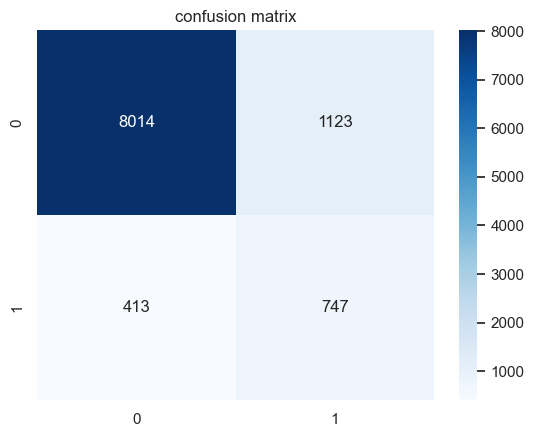

In [96]:
try:
    best_pipeline
except NameError:
    best_pipeline = best_pipeline_quick

best_pipeline.fit(X_train, y_train)

y_pred_final = best_pipeline.predict(X_test)
y_proba_final = best_pipeline.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred_final))
print('Accuracy score: ', accuracy_score(y_test, y_pred_final))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_final))
print("PR-AUC:", average_precision_score(y_test, y_proba_final))
print("Confusion metrix",confusion_matrix(y_test, y_pred_final))
sns.heatmap(confusion_matrix(y_test, y_pred_final), fmt='d', annot=True, cmap='Blues')
plt.title("confusion matrix")
plt.show()

#  Calibration (isotonic) & choose threshold
- Calibration improves probability estimates; useful if you will operate at a business threshold.

In [98]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

cal = CalibratedClassifierCV(best_pipeline, method='isotonic', cv=5)
cal.fit(X_train, y_train)
proba_cal = cal.predict_proba(X_test)[:,1]

print("Calibrated ROC-AUC:", roc_auc_score(y_test, proba_cal))
print("Calibrated PR-AUC:", average_precision_score(y_test, proba_cal))
print("Brier score:", brier_score_loss(y_test, proba_cal))

Calibrated ROC-AUC: 0.8172929883422084
Calibrated PR-AUC: 0.496017642517675
Brier score: 0.07430633300576828


# Model diagnostics: ROC curve

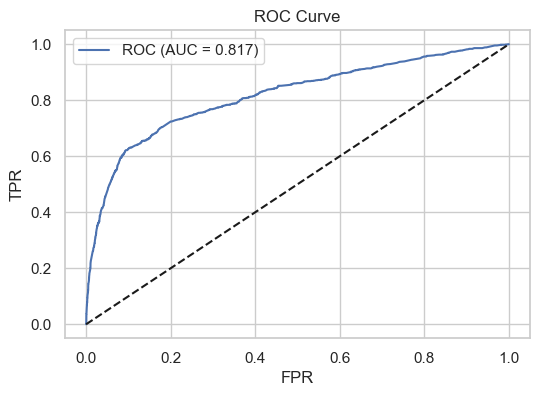

In [101]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, proba_cal)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc:.3f})')
plt.plot([0,1],[0,1], 'k--')
plt.xlabel('FPR'); 
plt.ylabel('TPR'); 
plt.title('ROC Curve'); 
plt.legend(); 
plt.show()

# Feature importances (RF) + readable names

,feature,importance
0,nr.employed,0.355546
1,euribor3m,0.216058
2,emp.var.rate,0.100151
3,cons.conf.idx,0.061158
4,age,0.028247
5,pdays_when_contacted,0.026429
6,cons.price.idx,0.023620
7,campaign,0.020082
8,month_may,0.018981
9,month_oct,0.018691


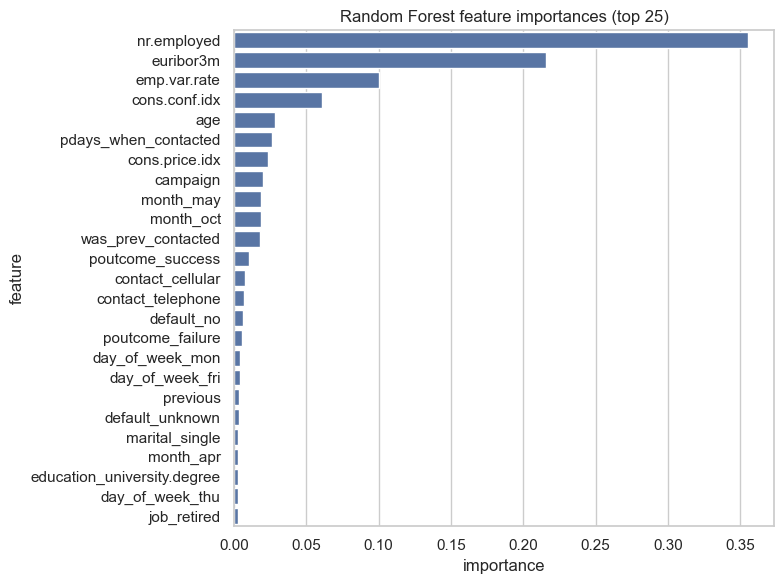

In [108]:
# Extract feature names from preprocessor
pre = best_pipeline.named_steps['pre']
clf = best_pipeline.named_steps['clf']

# Get categorical feature names from the encoder
ohe = pre.named_transformers_['cat']
cat_feature_names = list(ohe.get_feature_names_out(cat_cols))

# Combine with numeric column names
feature_names = cat_feature_names + num_cols

# Create importance DataFrame
imp = pd.DataFrame({
    'feature': feature_names,
    'importance': clf.feature_importances_
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

# Display top 20
display(imp.head(20))

# Plot top 25
plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=imp.head(25))
plt.title('Random Forest feature importances (top 25)')
plt.tight_layout()
plt.show()


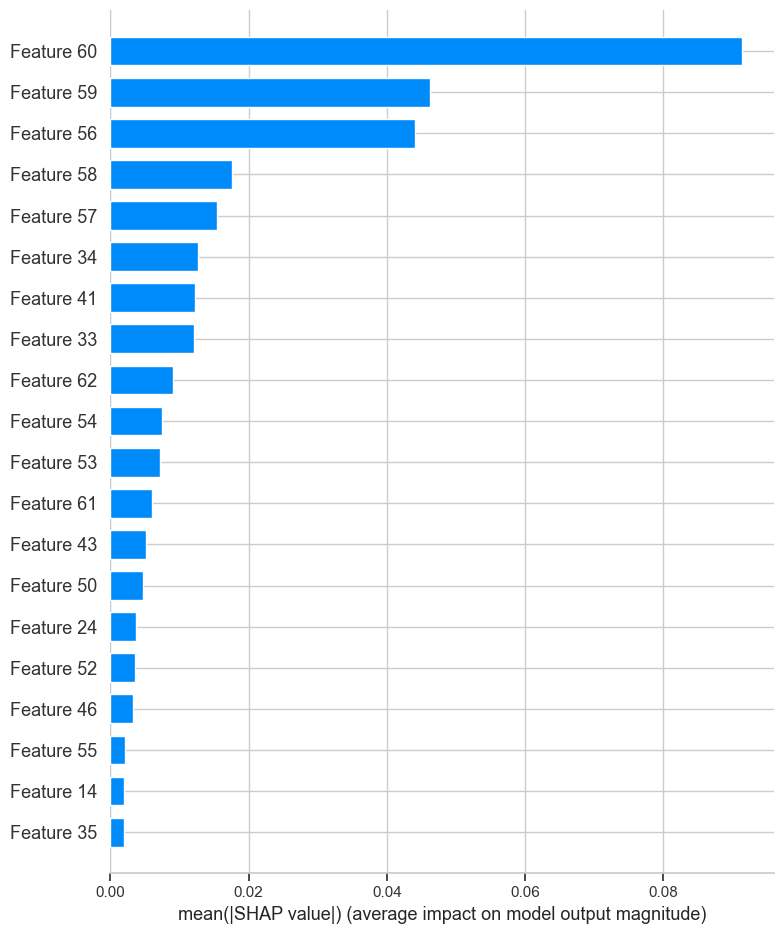

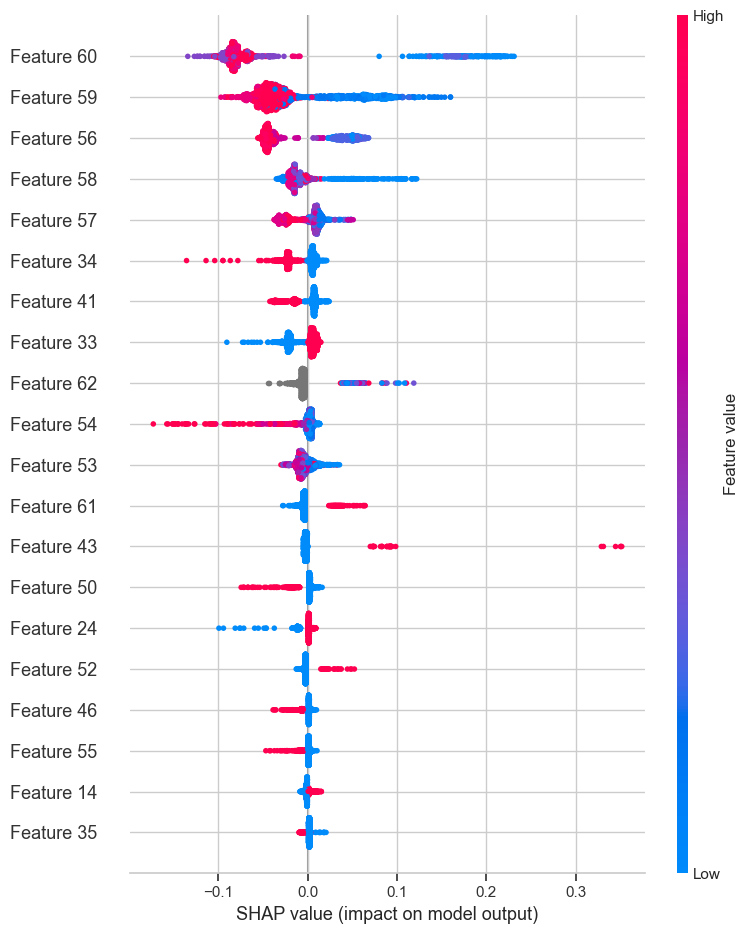

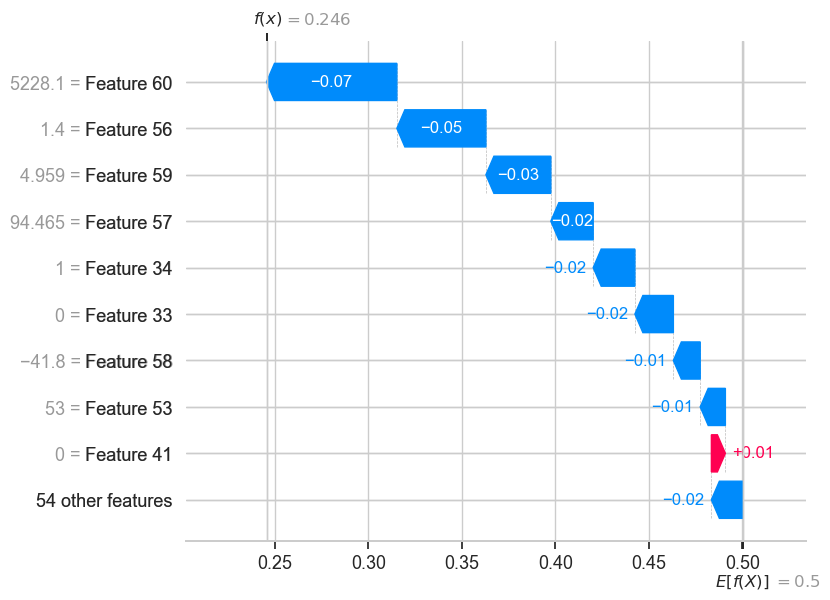

In [113]:
# Cell 18
import shap
# transform X_test to preprocessor output (dense)
X_test_pre = pre.transform(X_test)
if hasattr(X_test_pre, "toarray"):
    X_test_pre = X_test_pre.toarray()
# sample
shap_sample_n = min(2000, X_test_pre.shape[0])
sample_idx = np.random.RandomState(RANDOM_STATE).choice(X_test_pre.shape[0], shap_sample_n, replace=False)
X_shap = X_test_pre[sample_idx]

explainer = shap.TreeExplainer(clf)
shap_values_raw = explainer.shap_values(X_shap)  # might be list or ndarray
# normalize to (n_samples, n_features) for positive class (1)
if isinstance(shap_values_raw, list):
    class_idx = 1  # binary: index 1 corresponds to 'yes' / target=1
    sv = np.array(shap_values_raw[class_idx])
elif isinstance(shap_values_raw, np.ndarray) and shap_values_raw.ndim == 3:
    sv = shap_values_raw[:, :, 1]
else:
    sv = np.array(shap_values_raw)

# drop bias column if present
if sv.shape[1] == X_shap.shape[1] + 1:
    sv = sv[:, :-1]

assert sv.shape[1] == X_shap.shape[1]

# Feature names match
fn = feature_names

# SHAP plots
shap.summary_plot(sv, features=X_shap, feature_names=fn, plot_type='bar')
shap.summary_plot(sv, features=X_shap, feature_names=fn)





# Single sample waterfall — binary target safe
single_exp = explainer(X_shap[0:1])

# If binary, shap_values will be length-2 list or Explanation with multi-output
if isinstance(single_exp.values, np.ndarray) and single_exp.values.ndim == 2:
    # Already single-output (n_samples, n_features) — good
    shap.plots.waterfall(single_exp[0])
elif isinstance(single_exp.values, np.ndarray) and single_exp.values.ndim == 3:
    # Multi-output (n_samples, n_features, n_classes) — take class 1
    from shap import Explanation
    class_idx = 1
    sv_class1 = single_exp.values[:, :, class_idx]
    base_class1 = single_exp.base_values[:, class_idx]
    data = single_exp.data
    feature_names = single_exp.feature_names
    exp_class1 = Explanation(values=sv_class1,
                             base_values=base_class1,
                             data=data,
                             feature_names=feature_names)
    shap.plots.waterfall(exp_class1[0])
else:
    # If shap returns list (older versions), take index 1
    shap.plots.waterfall(single_exp[1][0])


# Save pipeline, feature names & outputs (for GitHub)

In [114]:
# Cell 20
joblib.dump(cal, "rf_bank_marketing_calibrated.joblib")
pd.Series(feature_names).to_csv("encoded_feature_names.csv", index=False)
imp.head(25).to_csv("feature_importances_top25.csv", index=False)
print("Saved: models/rf_bank_marketing_calibrated.joblib, models/encoded_feature_names.csv, outputs/feature_importances_top25.csv")


Saved: models/rf_bank_marketing_calibrated.joblib, models/encoded_feature_names.csv, outputs/feature_importances_top25.csv
